This lab was written by Christophe Avenel, and his code is available here: https://github.com/NBISweden/workshop-neural-nets-and-deep-learning/tree/master/session_convolutionalNeuralNetworks/Labs

# CNN Lab 2: Segmentation of Human Blood Cells using Convolutional Neural Networks

For this lab, we use the [Human White Blood Cell images](https://github.com/zxaoyou/segmentation_WBC) from [Jiangxi Tecom Science Corporation, China](http://en.tecom-cn.com/).

<img src="Illustrations/WhiteBloodCells.png" width="500px" title="Blood cell illustration (Wikipedia)" align="center"/>
<center><i>(Illustration from <a href="https://en.wikipedia.org/wiki/White_blood_cell">Wikipédia</a>)</i></center>

<br/>
The dataset contains three hundred 120x120 RGB images with one blood cell per image, and corresponding segmentation masks. The segmentation mask was manually sketched by domain experts, with the background, cytoplasms and nuclei pixels labelled as 0, 1 and 2 respectively.

<img src="Illustrations/WBC_Dataset1.png" title="Blood cells dataset" align="center"/>

These images and masks are in the **LabData/bloodcells_seg/** folder:
```
└── data
    └── bloodcells_seg
        ├── masks
        │   ├── all
        └── images
            ├── all
```

We want to use convolutional neural networks to do pixel-wise classification of these blood cells images into background / cytoplasm / nuclei.

In [6]:
# First we import useful modules like numpy and Keras layers

import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, Input
from tensorflow.keras.layers import Conv2DTranspose, concatenate, UpSampling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# cnn_helper contains some useful functions for this lab
import cnn_helper

import tensorflow as tf
import matplotlib.pyplot as plt

We will load both the images and the masks as generators, and combine both generators into a zip of generators.

In [8]:
IMG_SIZE = 128
NUM_CLASSES = 3 # Background, cytoplasm, nuclei
N_CHANNELS = 3  # R,G,B
BATCH_SIZE = 8  # You can tune this and see which batch size runs faster / gives the best accuracy.

seed = 909 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
image_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255 #We need to rescale png images from 0-255 integers to 0.0-1.0 floats.
)
mask_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Load image and mask generators for training:
train_image_generator = image_datagen.flow_from_directory(
    directory='LabData/bloodcells_seg/images/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None, 
    seed=seed,
    subset='training',
    color_mode='rgb',
    shuffle=False)
# Note: the class_mode is used when the class is extracted from the directory
# structure. Here the class will be defined by the mask from the generator below, 
# so we add class_mode: None

train_mask_generator = mask_datagen.flow_from_directory(
    directory='LabData/bloodcells_seg/masks/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='training',
    color_mode='grayscale',
    shuffle=False)

train_generator = zip(train_image_generator, train_mask_generator)

# Load image and mask  generators for validation:
val_image_generator = image_datagen.flow_from_directory(
    directory='LabData/bloodcells_seg/images/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='validation',
    color_mode='rgb',
    shuffle=False)

val_mask_generator = mask_datagen.flow_from_directory(
    directory='LabData/bloodcells_seg/masks/',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode=None,
    seed=seed,
    subset='validation',
    color_mode='grayscale',
    shuffle=False)

val_generator = zip(val_image_generator, val_mask_generator)

Found 240 images belonging to 1 classes.
Found 240 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Found 60 images belonging to 1 classes.


We can now check that the generators deliver our data:

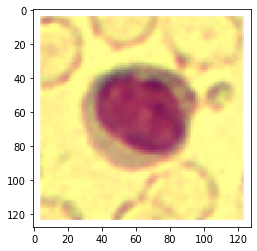

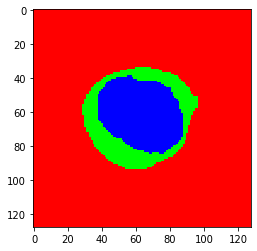

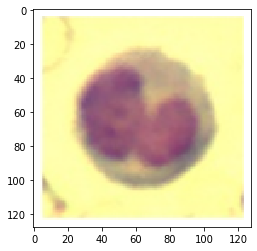

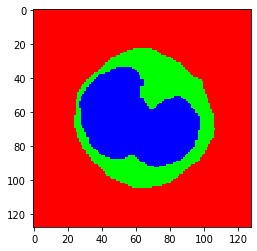

In [9]:
from matplotlib.colors import ListedColormap
cMap = ListedColormap(['red', 'lime', 'blue'])

images,masks = next(train_generator)
for i in range(0,2):
    plt.figure()
    plt.imshow(images[i], cmap=cMap)
    plt.figure()
    plt.imshow(masks[i,:,:,0], cmap=cMap)

# Building a UNet Model

<img src="Illustrations/unet.png" title="Unet model"/>

This time we will use the Keras functional API to build our model:

In [10]:
inputs = Input((IMG_SIZE, IMG_SIZE, N_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(NUM_CLASSES, (1, 1), activation='softmax') (c9)

We use the **ELU** activation function, as the negative values and the smooth transition from negative to positive helps us have faster results in a low number of epochs. But you can try other activations functions easily:
<img src="Illustrations/Activations.png" width="400px"/>
You can visualize differences between activation functions with this online tool from [Justin Emery](https://tech.courses/author/justinjustinemery-co-uk/):

In [11]:
from IPython.display import IFrame
IFrame('https://polarisation.github.io/tfjs-activation-functions/', width=860, height=470)

As our ground truth is represented by integers on a mask (0 for background, 1 for cytoplasm, 2 for nuclei pixels) and not hot-one encoded, we will use the Keras SparseCategoricalCrossentropy loss function (see https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

In [12]:
model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

For training, we add a callback function that will plot `num_plot` results from validation after each epoch, to follow in real time the training of our network.

<i>A callback function is a function that is called when some events are raised. Here, the function will be called after each epoch, and will plot example of prediction from the validation set.</i>

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30.0 steps, validate for 8.0 steps
Epoch 1/20
28/30 [===========================>..] - ETA: 0s - loss: 1.5648 - accuracy: 0.4109

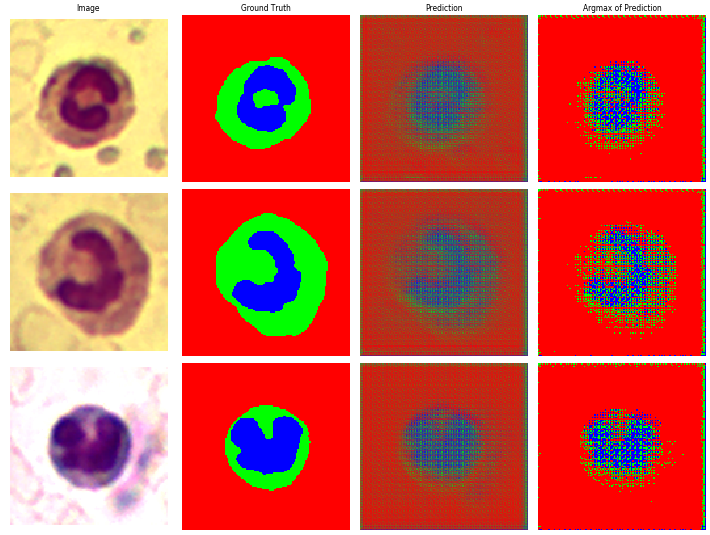

30/30 [==============================] - 6s 209ms/step - loss: 1.5061 - accuracy: 0.4309 - val_loss: 0.6241 - val_accuracy: 0.7662
Epoch 2/20
28/30 [===========================>..] - ETA: 0s - loss: 0.4992 - accuracy: 0.7958

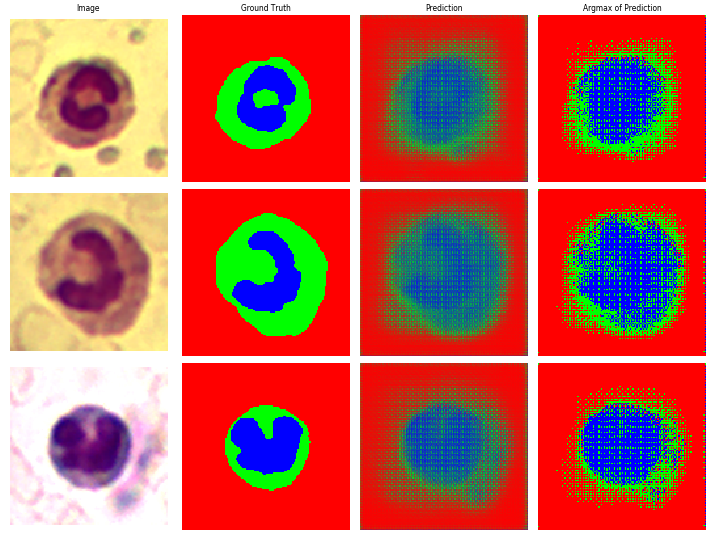

30/30 [==============================] - 2s 73ms/step - loss: 0.4897 - accuracy: 0.7994 - val_loss: 0.4441 - val_accuracy: 0.8224
Epoch 3/20
28/30 [===========================>..] - ETA: 0s - loss: 0.3342 - accuracy: 0.8590

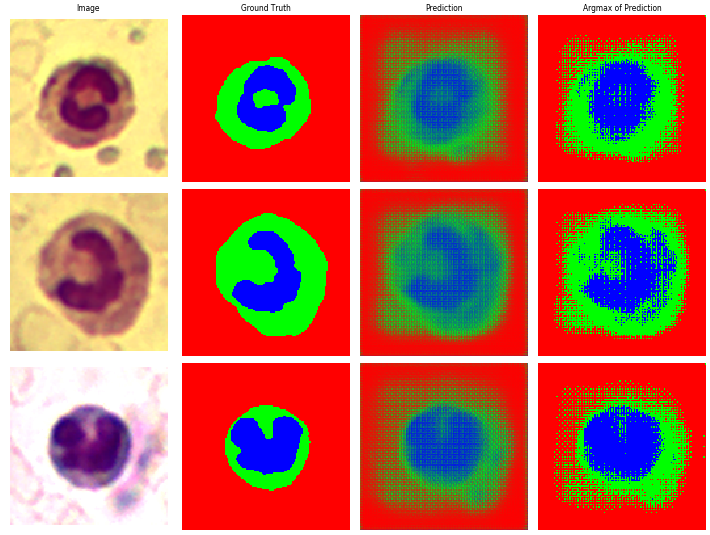

30/30 [==============================] - 2s 65ms/step - loss: 0.3297 - accuracy: 0.8610 - val_loss: 0.4495 - val_accuracy: 0.8267
Epoch 4/20
28/30 [===========================>..] - ETA: 0s - loss: 0.2732 - accuracy: 0.8885

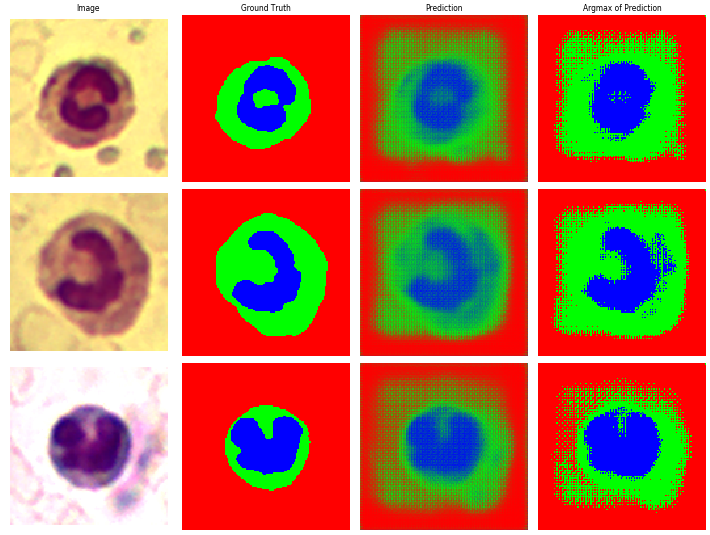

30/30 [==============================] - 2s 65ms/step - loss: 0.2694 - accuracy: 0.8903 - val_loss: 0.4855 - val_accuracy: 0.7852
Epoch 5/20
28/30 [===========================>..] - ETA: 0s - loss: 0.2361 - accuracy: 0.9076

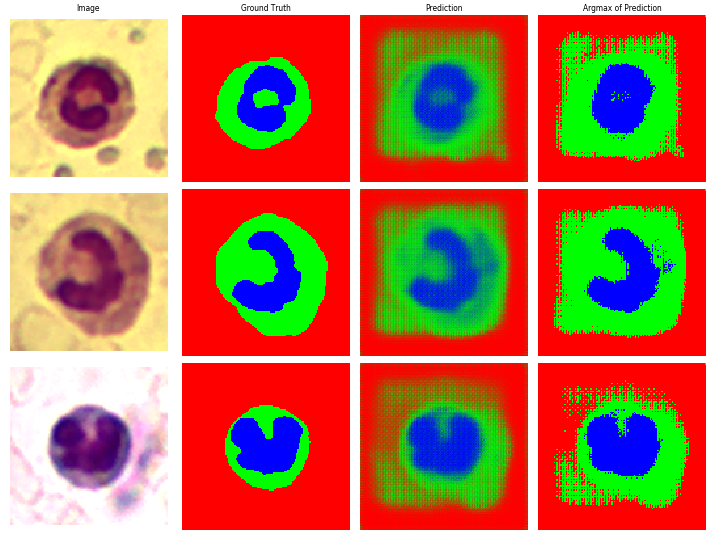

30/30 [==============================] - 2s 58ms/step - loss: 0.2328 - accuracy: 0.9091 - val_loss: 0.4281 - val_accuracy: 0.7960
Epoch 6/20
28/30 [===========================>..] - ETA: 0s - loss: 0.2050 - accuracy: 0.9209

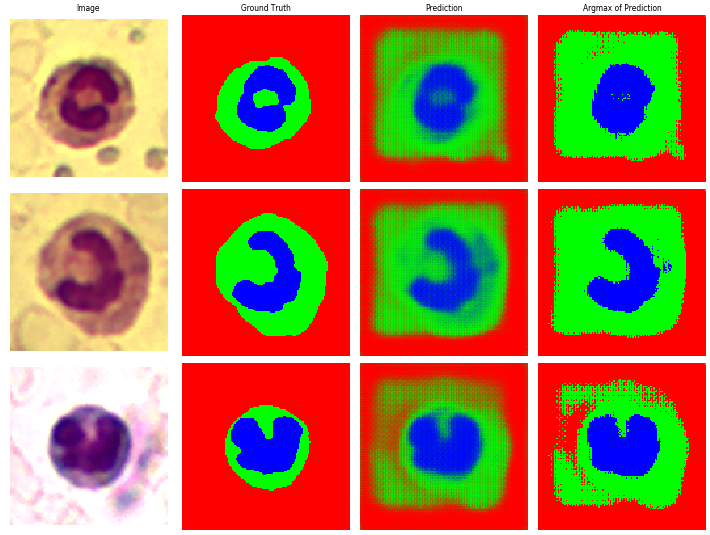

30/30 [==============================] - 2s 59ms/step - loss: 0.2020 - accuracy: 0.9222 - val_loss: 0.5147 - val_accuracy: 0.7367
Epoch 7/20
29/30 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9309

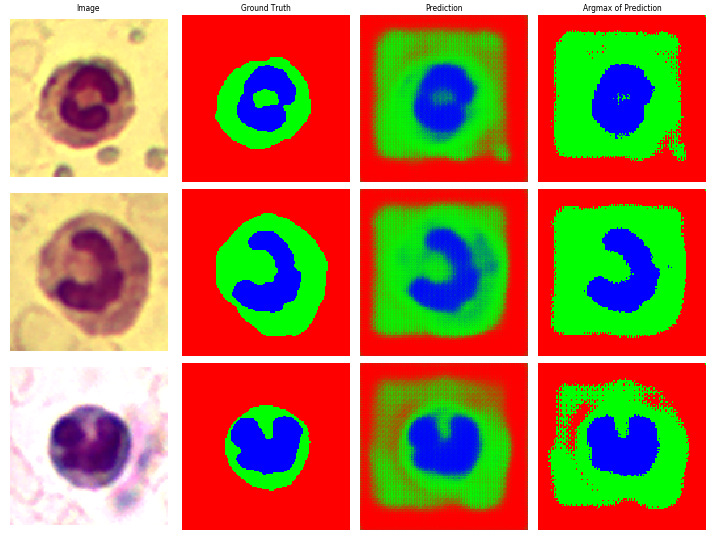

30/30 [==============================] - 2s 59ms/step - loss: 0.1788 - accuracy: 0.9315 - val_loss: 0.5569 - val_accuracy: 0.7217
Epoch 8/20
28/30 [===========================>..] - ETA: 0s - loss: 0.1659 - accuracy: 0.9372

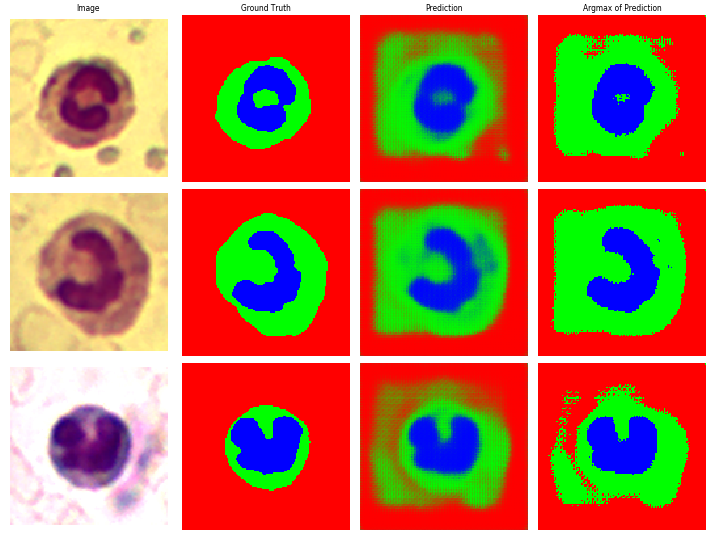

30/30 [==============================] - 2s 61ms/step - loss: 0.1633 - accuracy: 0.9382 - val_loss: 0.4585 - val_accuracy: 0.7704
Epoch 9/20
28/30 [===========================>..] - ETA: 0s - loss: 0.1510 - accuracy: 0.9431

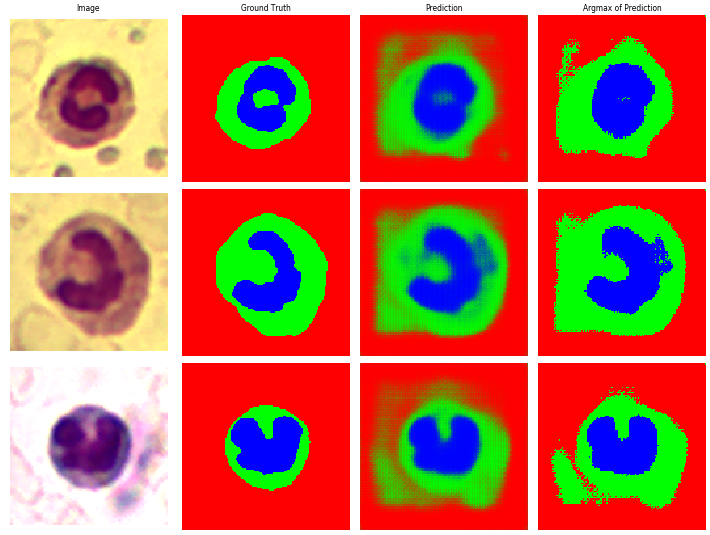

30/30 [==============================] - 2s 51ms/step - loss: 0.1487 - accuracy: 0.9440 - val_loss: 0.3687 - val_accuracy: 0.8113
Epoch 10/20
28/30 [===========================>..] - ETA: 0s - loss: 0.1436 - accuracy: 0.9462

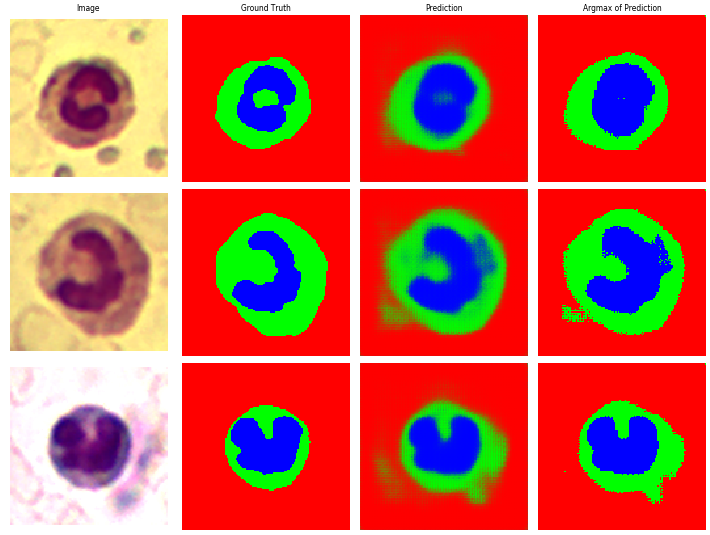

30/30 [==============================] - 2s 55ms/step - loss: 0.1414 - accuracy: 0.9469 - val_loss: 0.1772 - val_accuracy: 0.9262
Epoch 11/20
29/30 [============================>.] - ETA: 0s - loss: 0.1381 - accuracy: 0.9477

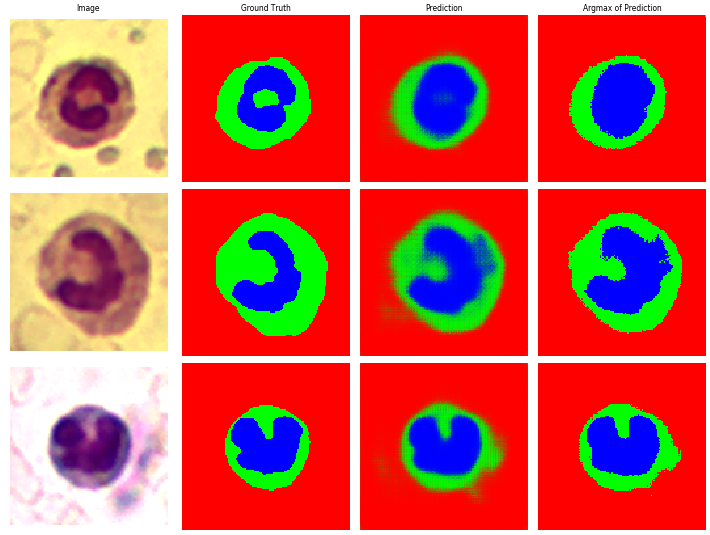

30/30 [==============================] - 1s 50ms/step - loss: 0.1371 - accuracy: 0.9481 - val_loss: 0.1402 - val_accuracy: 0.9453
Epoch 12/20
29/30 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9474

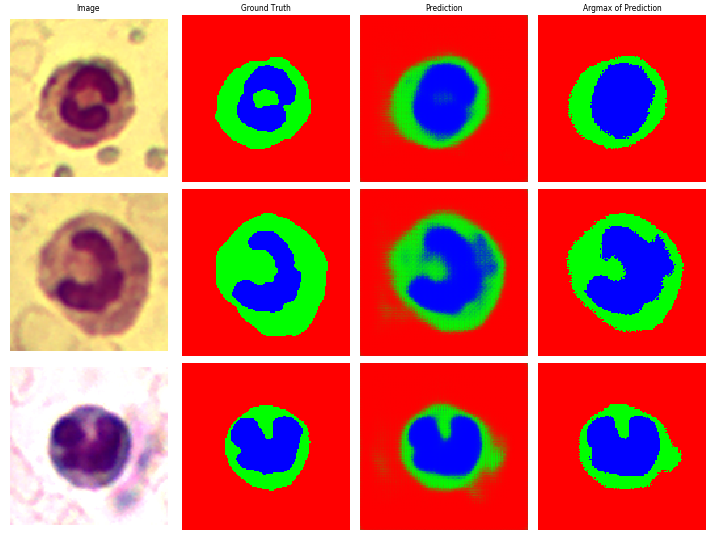

30/30 [==============================] - 1s 48ms/step - loss: 0.1379 - accuracy: 0.9479 - val_loss: 0.1499 - val_accuracy: 0.9418
Epoch 13/20
26/30 [=========================>....] - ETA: 0s - loss: 0.1232 - accuracy: 0.9531

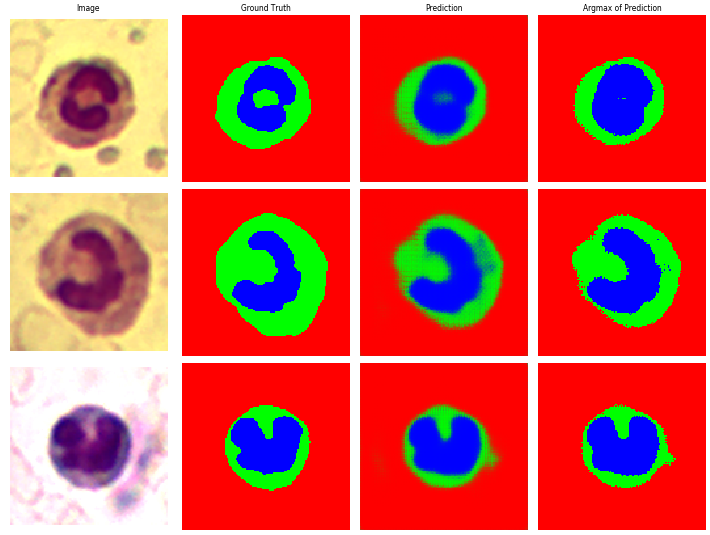

30/30 [==============================] - 2s 54ms/step - loss: 0.1216 - accuracy: 0.9538 - val_loss: 0.1505 - val_accuracy: 0.9427
Epoch 14/20
29/30 [============================>.] - ETA: 0s - loss: 0.1144 - accuracy: 0.9564

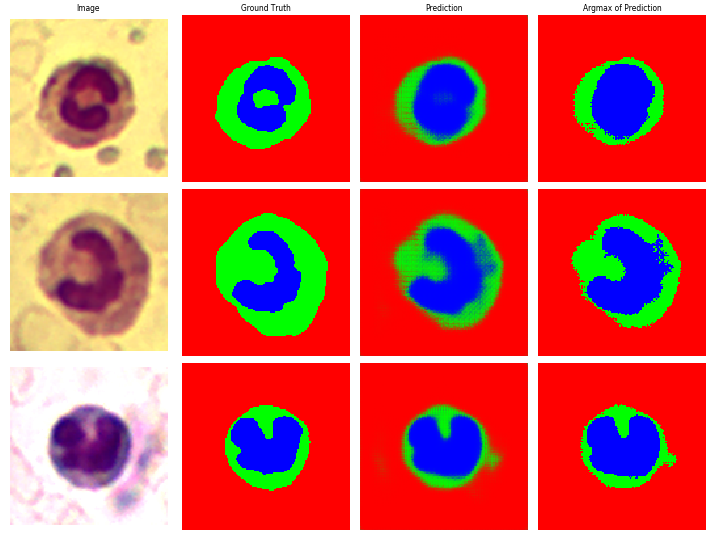

30/30 [==============================] - 1s 48ms/step - loss: 0.1135 - accuracy: 0.9567 - val_loss: 0.1647 - val_accuracy: 0.9359
Epoch 15/20
28/30 [===========================>..] - ETA: 0s - loss: 0.1112 - accuracy: 0.9574

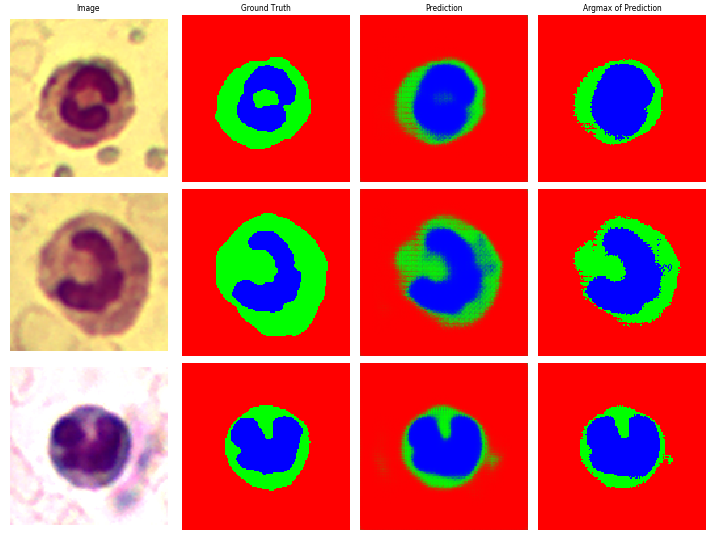

30/30 [==============================] - 2s 55ms/step - loss: 0.1097 - accuracy: 0.9579 - val_loss: 0.1963 - val_accuracy: 0.9253
Epoch 16/20
28/30 [===========================>..] - ETA: 0s - loss: 0.1060 - accuracy: 0.9592

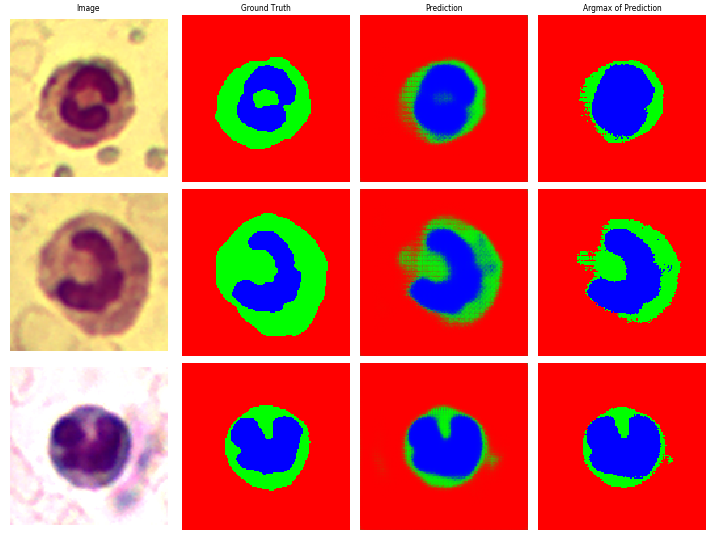

30/30 [==============================] - 2s 56ms/step - loss: 0.1045 - accuracy: 0.9597 - val_loss: 0.2018 - val_accuracy: 0.9243
Epoch 17/20
28/30 [===========================>..] - ETA: 0s - loss: 0.0996 - accuracy: 0.9615

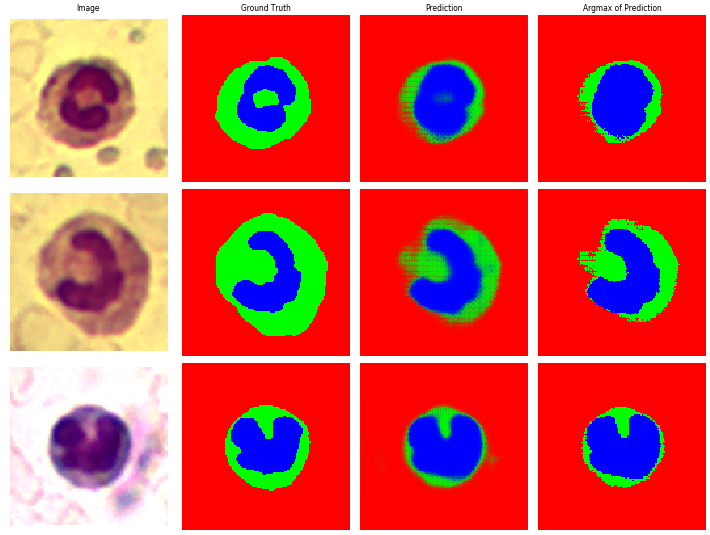

30/30 [==============================] - 1s 48ms/step - loss: 0.0984 - accuracy: 0.9619 - val_loss: 0.2368 - val_accuracy: 0.9153
Epoch 18/20
26/30 [=========================>....] - ETA: 0s - loss: 0.0965 - accuracy: 0.9626

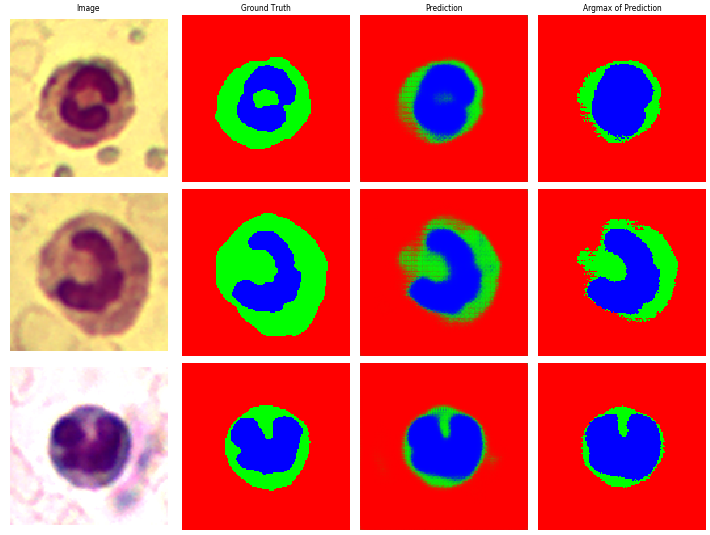

30/30 [==============================] - 1s 48ms/step - loss: 0.0953 - accuracy: 0.9631 - val_loss: 0.2344 - val_accuracy: 0.9168
Epoch 19/20
27/30 [==========================>...] - ETA: 0s - loss: 0.0946 - accuracy: 0.9631

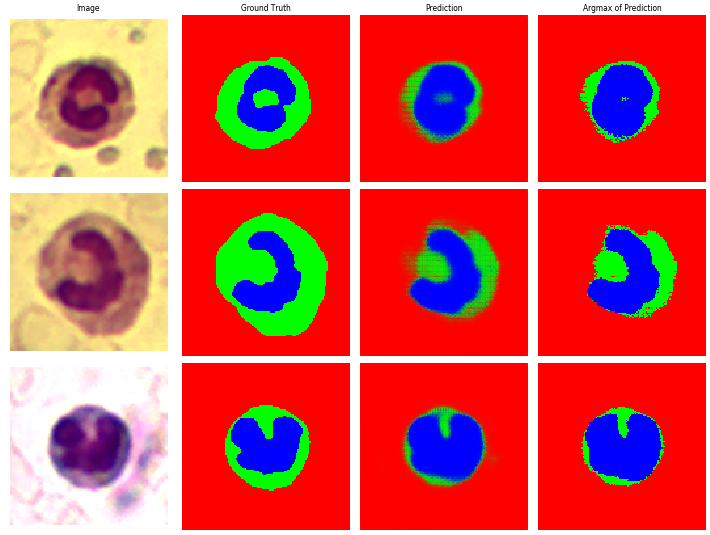

30/30 [==============================] - 2s 54ms/step - loss: 0.0934 - accuracy: 0.9636 - val_loss: 0.3042 - val_accuracy: 0.8977
Epoch 20/20
28/30 [===========================>..] - ETA: 0s - loss: 0.0893 - accuracy: 0.9654

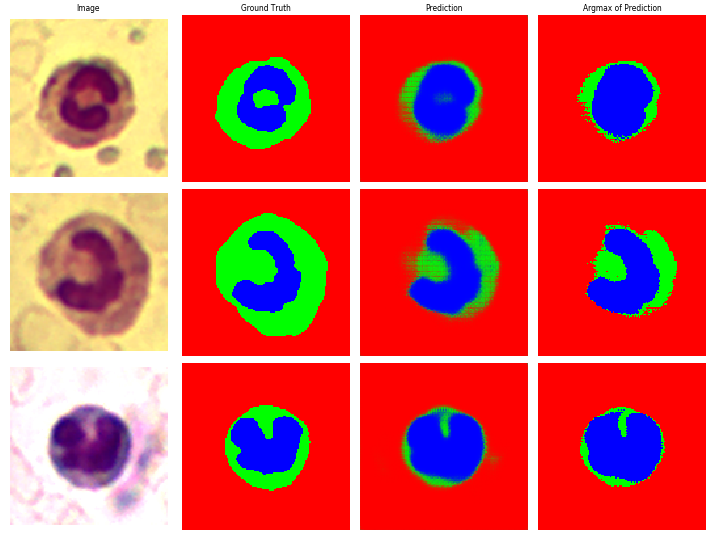

30/30 [==============================] - 1s 48ms/step - loss: 0.0884 - accuracy: 0.9657 - val_loss: 0.3049 - val_accuracy: 0.8970


In [13]:
plot_callback = cnn_helper.PlottingKerasCallback(
    test_batch=next(val_generator),
    num_plot=3 # how many validation examples to plot at each epoch (maximum = BATCH_SIZE)
)

model.fit(
    train_generator,
    steps_per_epoch=240/BATCH_SIZE, 
    epochs=20,
    validation_data=(val_generator),
    validation_steps=64/BATCH_SIZE, 
    callbacks=[plot_callback]
)

We can now plot some other examples from validation:

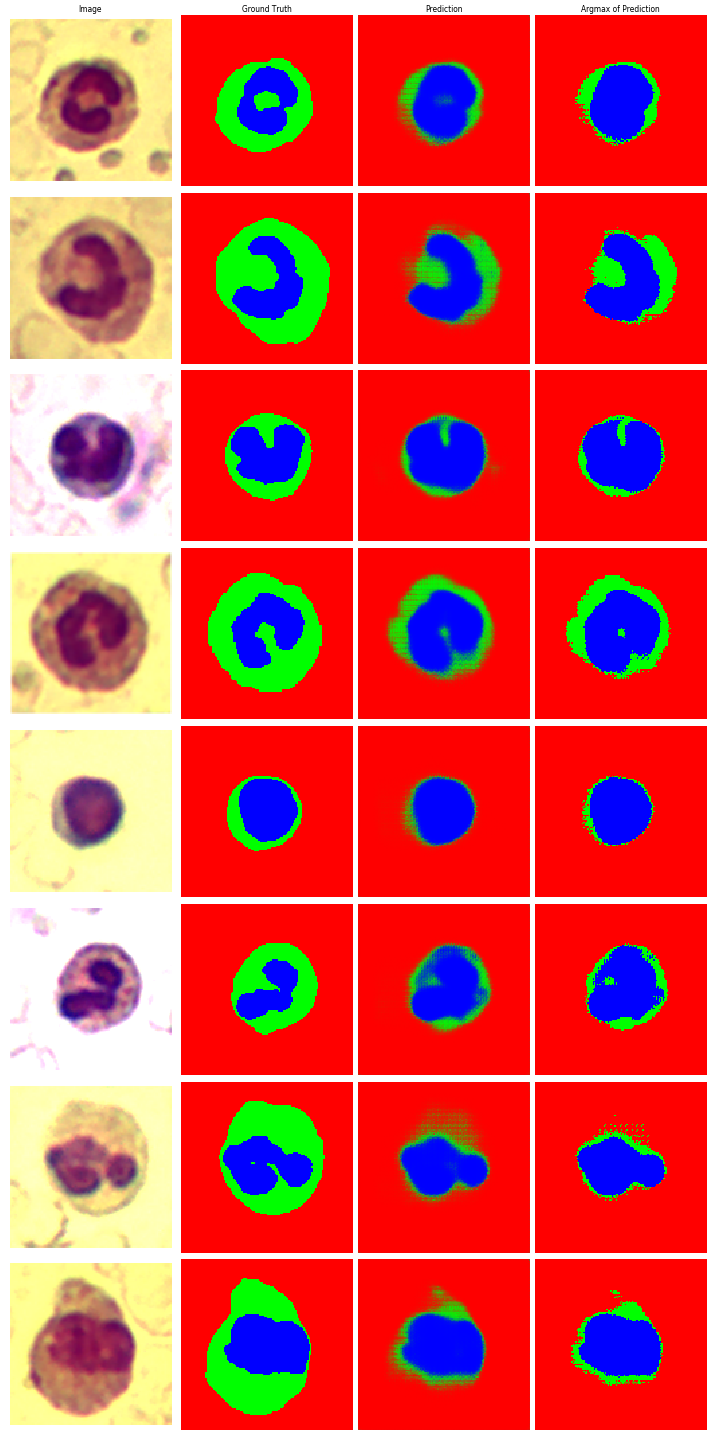

In [14]:
cnn_helper.plot_prediction (model, next(val_generator), BATCH_SIZE)

## Tuning of the model
You can now try to tune your model by changing the learning rate of the Adam optimizer, the dropout, the batch size, or any other parameter you want.

# Other models

To simplify the construction of our networks, we will now use the `segmentation_model` python library (install using `pip install segmentation_model`).

The main features of this library are:
 - High level API (just two lines of code to create model for segmentation)
 - 4 models architectures for binary and multi-class image segmentation (including legendary Unet)
 - 25 available backbones for each architecture
 
You can read more about the `segmentation_model` library at https://github.com/qubvel/segmentation_models.

## List of models:

| Unet | Linknet |
| --- | --- |
| <img width="500px" src="https://raw.githubusercontent.com/qubvel/segmentation_models/master/images/unet.png" title="UNet"/> | <img width="500px" src="https://github.com/qubvel/segmentation_models/raw/master/images/linknet.png" title="Linknet"/> |

| PSPNet | FPN |
| --- | --- |
| <img width="500px" src="https://github.com/qubvel/segmentation_models/raw/master/images/pspnet.png" title="UNet"/> | <img width="500px" src="https://github.com/qubvel/segmentation_models/raw/master/images/fpn.png" title="Linknet"/> |

## List of backbones:

| Type | Names |
| --- | --- |
| VGG | `vgg16` `vgg19` |
| ResNet | `resnet18` `resnet34` `resnet50` `resnet101` `resnet152` |
| SE-ResNet | `seresnet18` `seresnet34` `seresnet50` `seresnet101` `seresnet152` |
| ResNeXt | `resnext50` `resnext101` |
| SE-ResNeXt | `seresnext50` `seresnext101` |
| SENet154 | `senet154` |
| DenseNet | `densenet121` `densenet169` `densenet201` |
| Inception | `inceptionv3` `inceptionresnetv2` |
| MobileNet | `mobilenet` `mobilenetv2` |
| EfficientNet | `efficientnetb0` `efficientnetb1` `efficientnetb2` `efficientnetb3` `efficientnetb4` `efficientnetb5` `efficientnetb6` `efficientnetb7` |

In [15]:
# This is needed for the segmentation_model library
import os
os.environ["SM_FRAMEWORK"]="tf.keras"

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


You can try different models and backbone from the list above.

<i>U-Net and Link-Net are very similar and generally used for the kind of segmentation we have here.<br/> FPN (Feature Pyramid Networks) are mainly used for object detection, and PSPNet (Pyramid Scene Parsing Networks) are not covered here, but you can read about them on https://towardsdatascience.com/review-pspnet-winner-in-ilsvrc-2016-semantic-segmentation-scene-parsing-e089e5df177d.

In [16]:
# Let's load the Unet model, using the VGG16 backbone
model = sm.Unet(
    'vgg16',
    encoder_weights=None,
    classes=NUM_CLASSES,
    activation='softmax',
    input_shape=(IMG_SIZE,IMG_SIZE,3)
)

print (model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

### We can now compile and train with the same parameters as before:

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 30.0 steps, validate for 8.0 steps
Epoch 1/30
28/30 [===========================>..] - ETA: 0s - loss: 1.0260 - accuracy: 0.4240

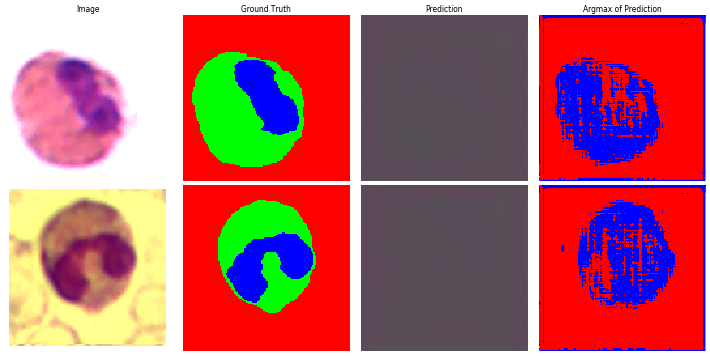

30/30 [==============================] - 6s 205ms/step - loss: 1.0139 - accuracy: 0.4424 - val_loss: 1.0616 - val_accuracy: 0.7431
Epoch 2/30
29/30 [============================>.] - ETA: 0s - loss: 0.7384 - accuracy: 0.8276

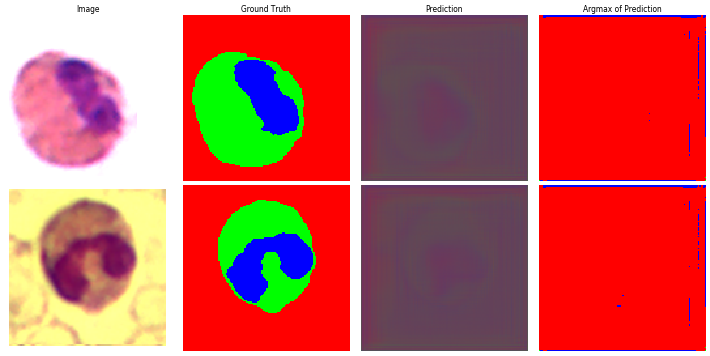

30/30 [==============================] - 2s 72ms/step - loss: 0.7355 - accuracy: 0.8293 - val_loss: 0.9980 - val_accuracy: 0.7097
Epoch 3/30
28/30 [===========================>..] - ETA: 0s - loss: 0.5945 - accuracy: 0.8957

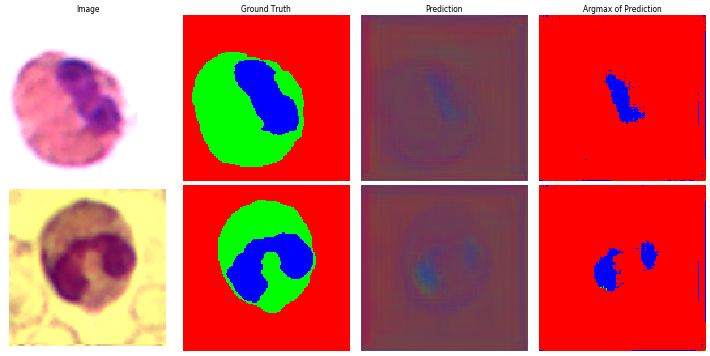

30/30 [==============================] - 2s 73ms/step - loss: 0.5916 - accuracy: 0.8957 - val_loss: 0.9070 - val_accuracy: 0.7594
Epoch 4/30
28/30 [===========================>..] - ETA: 0s - loss: 0.4721 - accuracy: 0.9334

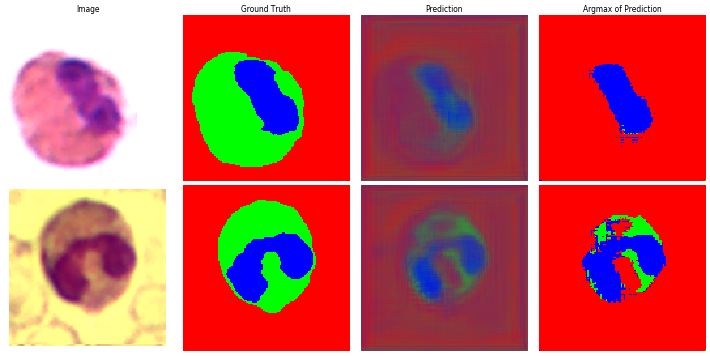

30/30 [==============================] - 2s 74ms/step - loss: 0.4694 - accuracy: 0.9336 - val_loss: 0.7384 - val_accuracy: 0.8288
Epoch 5/30
28/30 [===========================>..] - ETA: 0s - loss: 0.3715 - accuracy: 0.9557

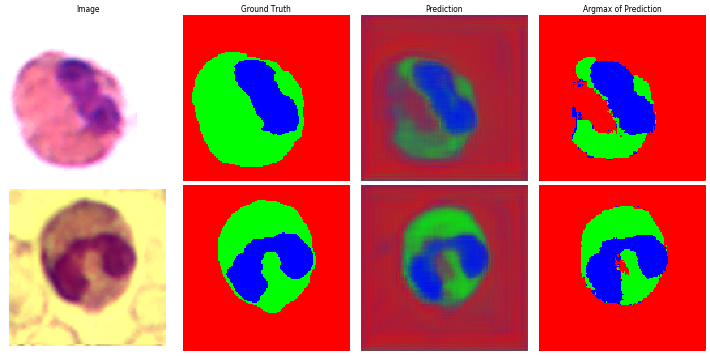

30/30 [==============================] - 2s 79ms/step - loss: 0.3695 - accuracy: 0.9554 - val_loss: 0.5581 - val_accuracy: 0.8865
Epoch 6/30
29/30 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.9627

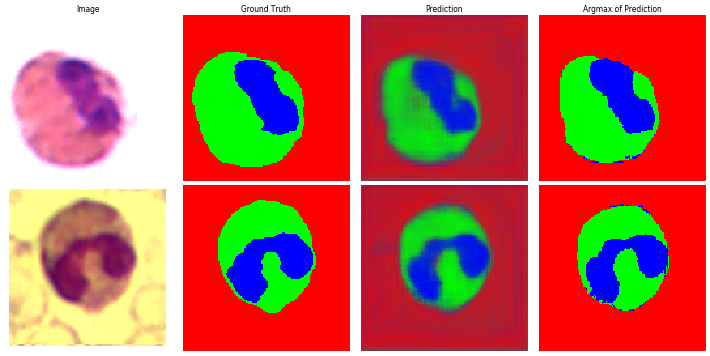

30/30 [==============================] - 2s 75ms/step - loss: 0.2981 - accuracy: 0.9627 - val_loss: 0.4133 - val_accuracy: 0.9296
Epoch 7/30
29/30 [============================>.] - ETA: 0s - loss: 0.2459 - accuracy: 0.9682

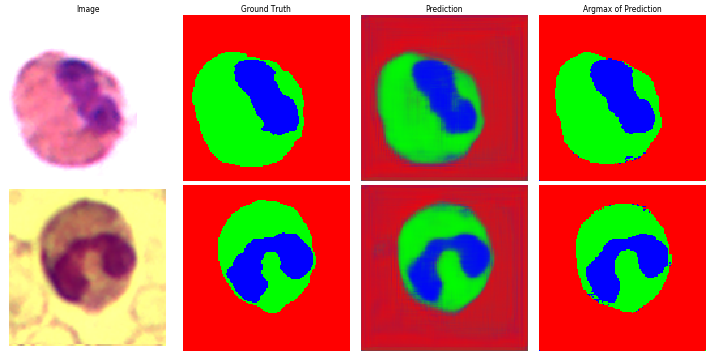

30/30 [==============================] - 2s 76ms/step - loss: 0.2451 - accuracy: 0.9682 - val_loss: 0.3043 - val_accuracy: 0.9579
Epoch 8/30
28/30 [===========================>..] - ETA: 0s - loss: 0.2063 - accuracy: 0.9719

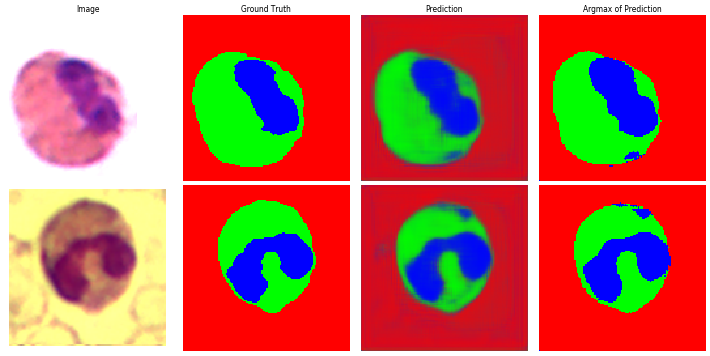

30/30 [==============================] - 2s 74ms/step - loss: 0.2053 - accuracy: 0.9718 - val_loss: 0.2612 - val_accuracy: 0.9671
Epoch 9/30
28/30 [===========================>..] - ETA: 0s - loss: 0.1744 - accuracy: 0.9747

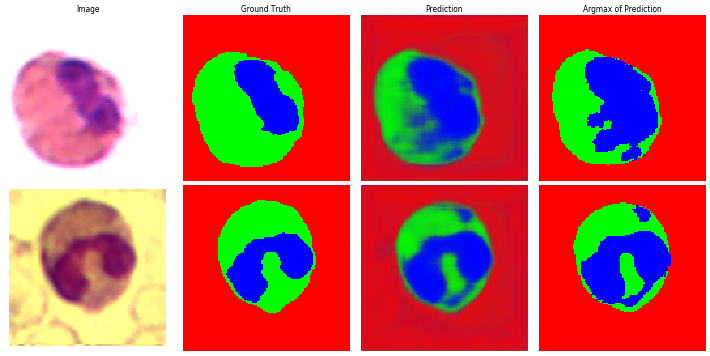

30/30 [==============================] - 2s 83ms/step - loss: 0.1737 - accuracy: 0.9747 - val_loss: 0.2587 - val_accuracy: 0.9507
Epoch 10/30
28/30 [===========================>..] - ETA: 0s - loss: 0.1517 - accuracy: 0.9758

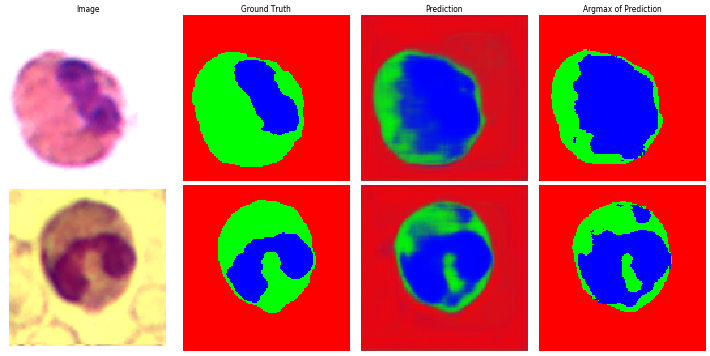

30/30 [==============================] - 2s 82ms/step - loss: 0.1511 - accuracy: 0.9758 - val_loss: 0.2761 - val_accuracy: 0.9282
Epoch 11/30
28/30 [===========================>..] - ETA: 0s - loss: 0.1318 - accuracy: 0.9778

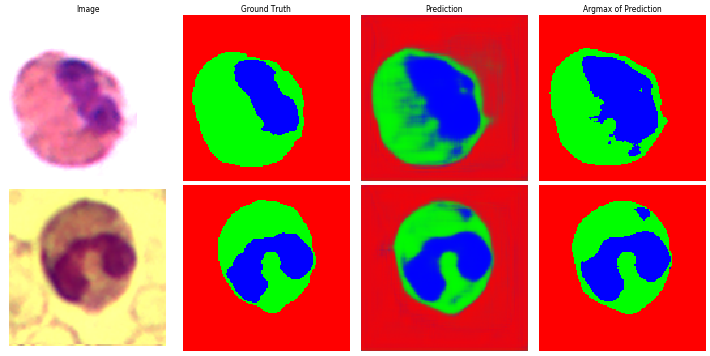

30/30 [==============================] - 2s 73ms/step - loss: 0.1313 - accuracy: 0.9778 - val_loss: 0.2044 - val_accuracy: 0.9517
Epoch 12/30
28/30 [===========================>..] - ETA: 0s - loss: 0.1172 - accuracy: 0.9791

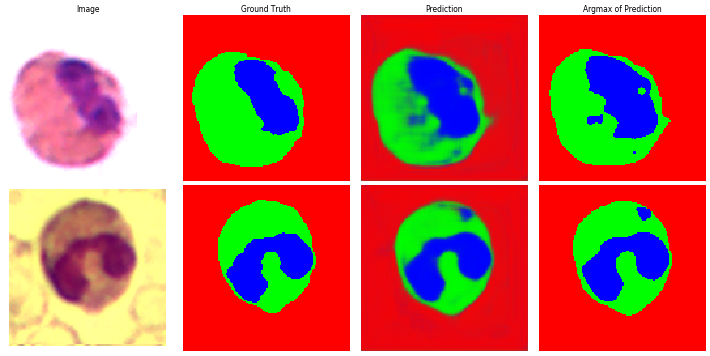

30/30 [==============================] - 2s 75ms/step - loss: 0.1167 - accuracy: 0.9791 - val_loss: 0.1617 - val_accuracy: 0.9645
Epoch 13/30
28/30 [===========================>..] - ETA: 0s - loss: 0.1058 - accuracy: 0.9799

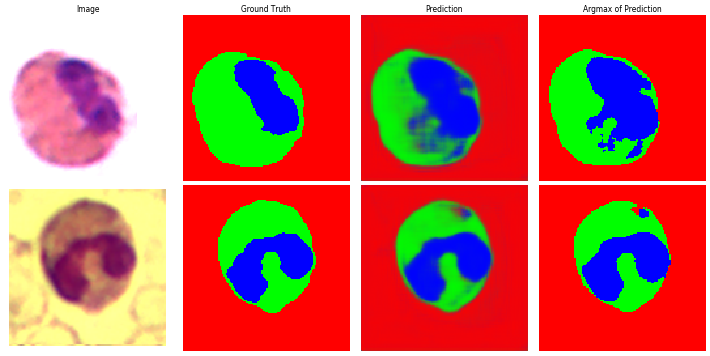

30/30 [==============================] - 2s 74ms/step - loss: 0.1054 - accuracy: 0.9799 - val_loss: 0.1463 - val_accuracy: 0.9669
Epoch 14/30
28/30 [===========================>..] - ETA: 0s - loss: 0.0964 - accuracy: 0.9806

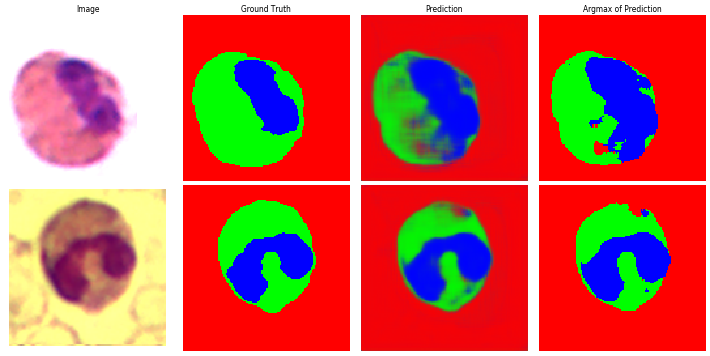

30/30 [==============================] - 2s 72ms/step - loss: 0.0961 - accuracy: 0.9806 - val_loss: 0.1721 - val_accuracy: 0.9524
Epoch 15/30
29/30 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9823

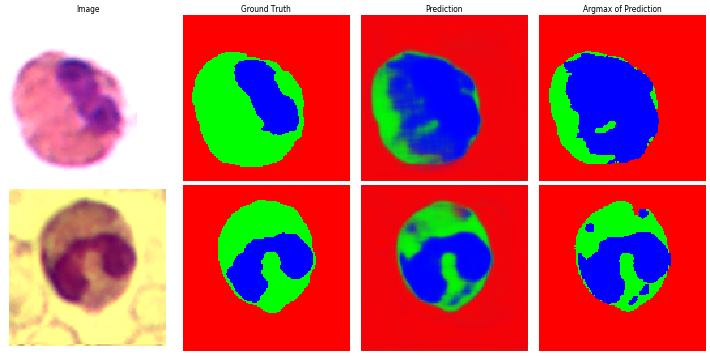

30/30 [==============================] - 2s 79ms/step - loss: 0.0868 - accuracy: 0.9822 - val_loss: 0.1774 - val_accuracy: 0.9438
Epoch 16/30
28/30 [===========================>..] - ETA: 0s - loss: 0.0799 - accuracy: 0.9832 ETA: 1s - loss:

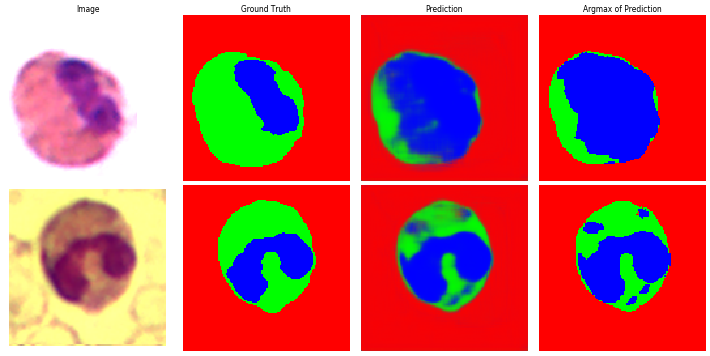

30/30 [==============================] - 2s 75ms/step - loss: 0.0796 - accuracy: 0.9832 - val_loss: 0.1927 - val_accuracy: 0.9362
Epoch 17/30
28/30 [===========================>..] - ETA: 0s - loss: 0.0764 - accuracy: 0.9827

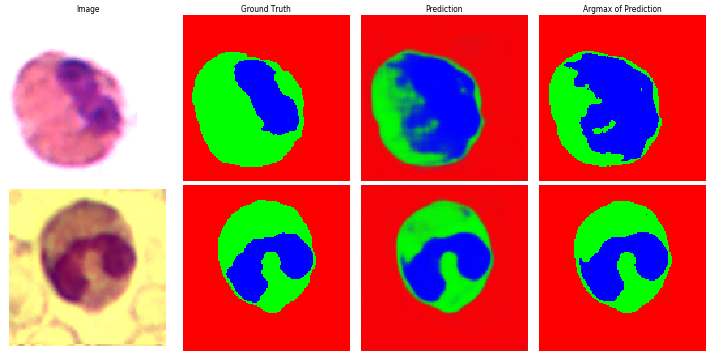

30/30 [==============================] - 2s 73ms/step - loss: 0.0761 - accuracy: 0.9828 - val_loss: 0.1177 - val_accuracy: 0.9658
Epoch 18/30
29/30 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9838

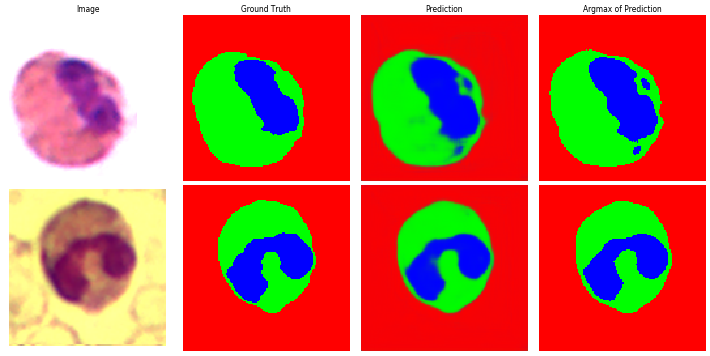

30/30 [==============================] - 2s 74ms/step - loss: 0.0706 - accuracy: 0.9837 - val_loss: 0.0808 - val_accuracy: 0.9792
Epoch 19/30
29/30 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9850

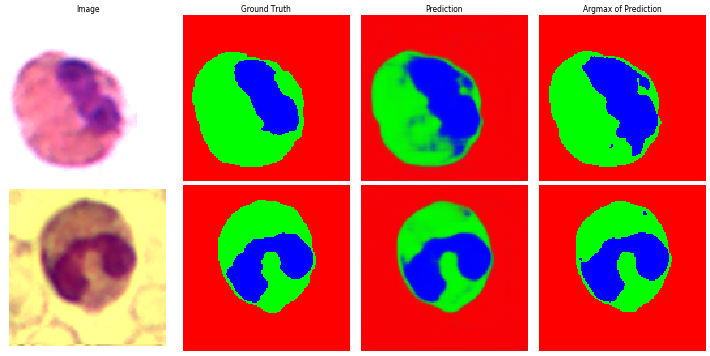

30/30 [==============================] - 2s 73ms/step - loss: 0.0647 - accuracy: 0.9850 - val_loss: 0.0887 - val_accuracy: 0.9751
Epoch 20/30
29/30 [============================>.] - ETA: 0s - loss: 0.0607 - accuracy: 0.9856

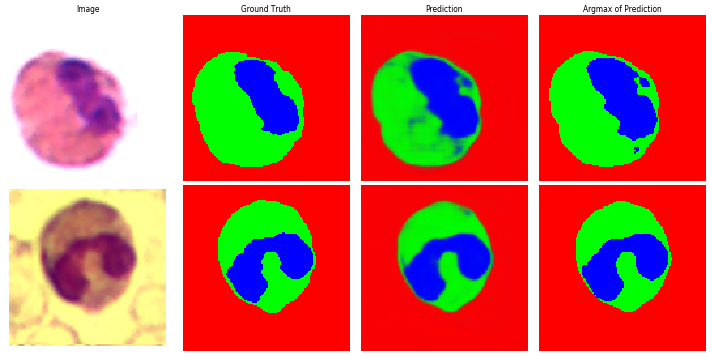

30/30 [==============================] - 2s 80ms/step - loss: 0.0607 - accuracy: 0.9856 - val_loss: 0.0874 - val_accuracy: 0.9756
Epoch 21/30
28/30 [===========================>..] - ETA: 0s - loss: 0.0587 - accuracy: 0.9855

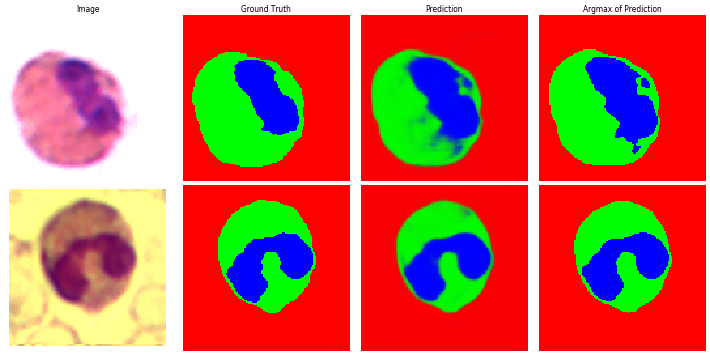

30/30 [==============================] - 2s 73ms/step - loss: 0.0586 - accuracy: 0.9855 - val_loss: 0.0749 - val_accuracy: 0.9790
Epoch 22/30
29/30 [============================>.] - ETA: 0s - loss: 0.0566 - accuracy: 0.9855

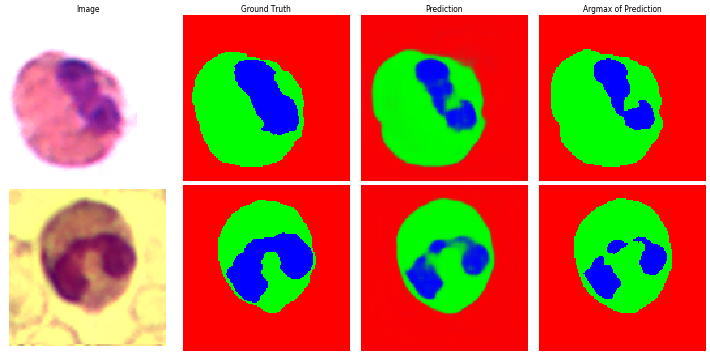

30/30 [==============================] - 2s 73ms/step - loss: 0.0566 - accuracy: 0.9855 - val_loss: 0.1444 - val_accuracy: 0.9533
Epoch 23/30
29/30 [============================>.] - ETA: 0s - loss: 0.0556 - accuracy: 0.9851

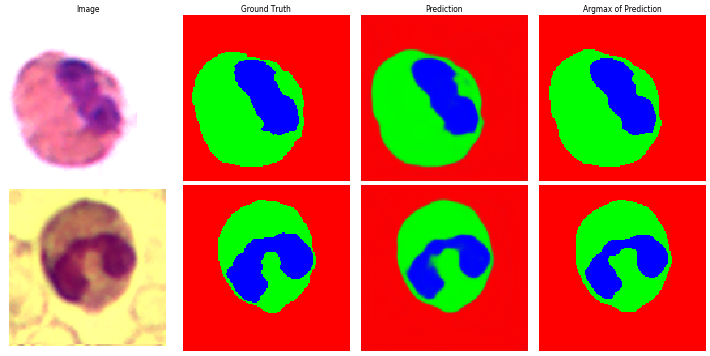

30/30 [==============================] - 2s 72ms/step - loss: 0.0558 - accuracy: 0.9851 - val_loss: 0.0751 - val_accuracy: 0.9771
Epoch 24/30
29/30 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.9865

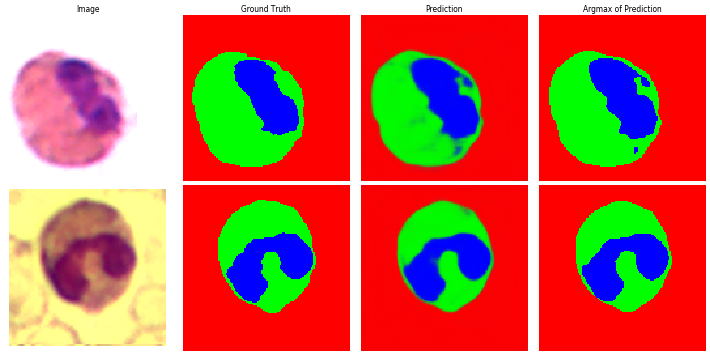

30/30 [==============================] - 2s 73ms/step - loss: 0.0513 - accuracy: 0.9863 - val_loss: 0.0696 - val_accuracy: 0.9788
Epoch 25/30
29/30 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9868

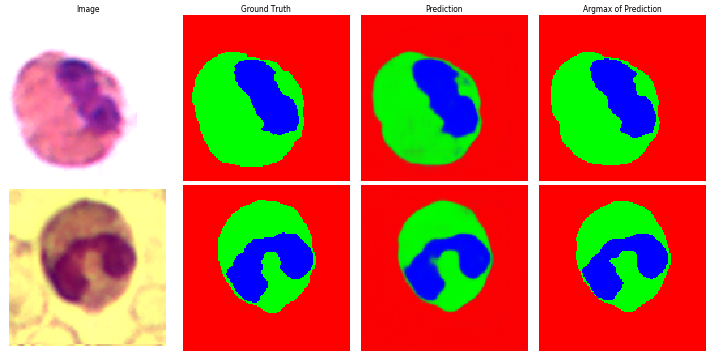

30/30 [==============================] - 2s 81ms/step - loss: 0.0493 - accuracy: 0.9866 - val_loss: 0.1033 - val_accuracy: 0.9686
Epoch 26/30
28/30 [===========================>..] - ETA: 0s - loss: 0.0486 - accuracy: 0.9863

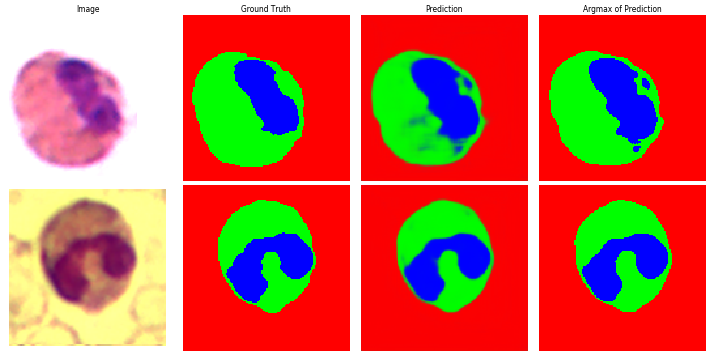

30/30 [==============================] - 2s 73ms/step - loss: 0.0486 - accuracy: 0.9864 - val_loss: 0.0734 - val_accuracy: 0.9769
Epoch 27/30
29/30 [============================>.] - ETA: 0s - loss: 0.0471 - accuracy: 0.9866

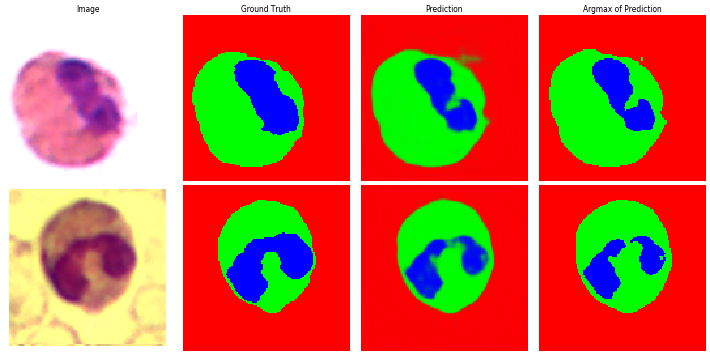

30/30 [==============================] - 2s 73ms/step - loss: 0.0471 - accuracy: 0.9865 - val_loss: 0.1093 - val_accuracy: 0.9646
Epoch 28/30
29/30 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.9868

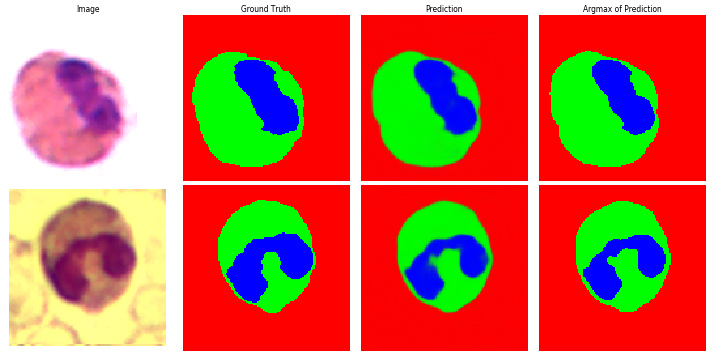

30/30 [==============================] - 2s 73ms/step - loss: 0.0453 - accuracy: 0.9868 - val_loss: 0.0851 - val_accuracy: 0.9723
Epoch 29/30
29/30 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9875

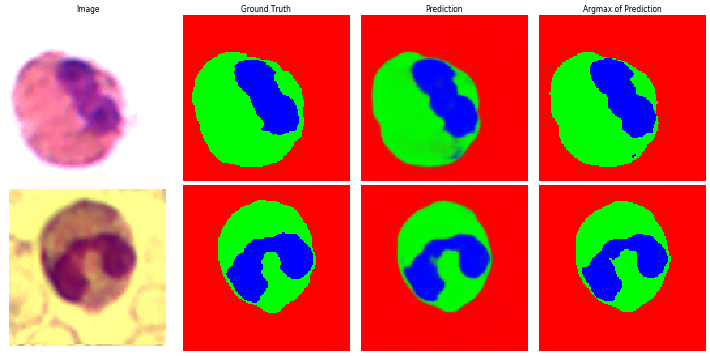

30/30 [==============================] - 2s 71ms/step - loss: 0.0430 - accuracy: 0.9875 - val_loss: 0.0825 - val_accuracy: 0.9735
Epoch 30/30
29/30 [============================>.] - ETA: 0s - loss: 0.0419 - accuracy: 0.9876

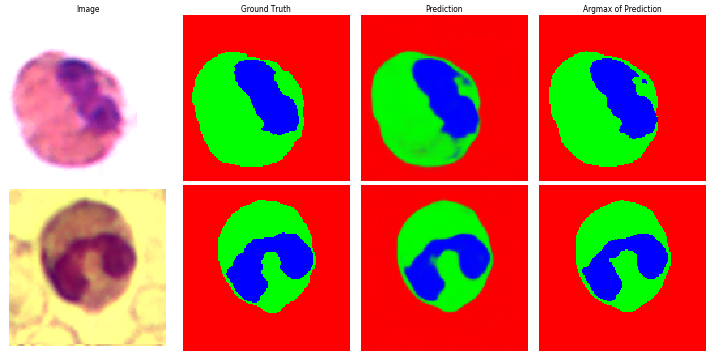

30/30 [==============================] - 3s 85ms/step - loss: 0.0419 - accuracy: 0.9876 - val_loss: 0.0682 - val_accuracy: 0.9782


In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.fit(
    train_generator,
    steps_per_epoch=240/BATCH_SIZE, 
    epochs=30,
    validation_data=(val_generator),
    validation_steps=64/BATCH_SIZE, 
    verbose=1,
    callbacks=[cnn_helper.PlottingKerasCallback(
        test_batch=next(val_generator),
        num_plot=2 # maximum num_plot is BATCH_SIZE
    )],
)

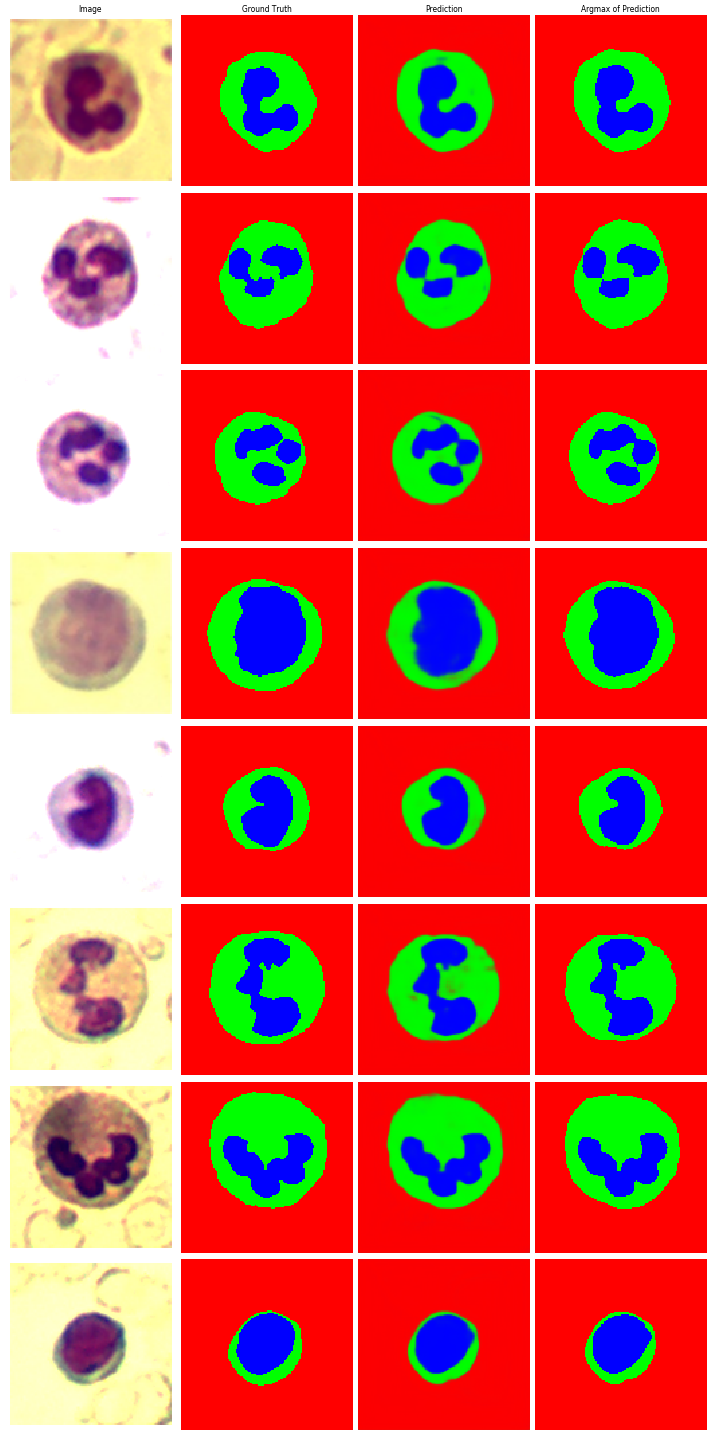

In [18]:
cnn_helper.plot_prediction (model, next(val_generator), BATCH_SIZE)